# Trotter Example

## TrotterPauliExpBox

- We can Trotterise a time evolution operator using the `TrotterPauliExpBox` class.

-  The `TrotterPauliExpBox` class is constructed from a sequence of pytket `PauliExpBox`s. Where there is one `PauliExpBox` for each term in the hamiltonian.

- For first order trotterisation we have:

$$ e^{-i H t} = (e^{-i a_1  P_1 t / n} e^{-i  a_2 P_2 t / n} \cdots )^n$$

- Where the hamiltonian is $H = a_1  P_1 + a_2 P_2 + \cdots$ 

## Ising Model

In [2]:
from qtnmtts.operators import ising_model
from qtnmtts.circuits.core import RegisterCircuit

n_state_qubits = 3
op = ising_model(n_qubits=3, h=1, j=1)
op_mat = op.to_sparse_matrix(n_state_qubits).todense()

- Measure the $Z$ basis on each qubit

In [3]:
from pytket.utils import QubitPauliOperator
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit

measurements = [QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1}) for i in range(n_state_qubits)]
measurements_mat = [op.to_sparse_matrix(n_state_qubits).todense() for op in measurements]

- Generate the circuit and corresponding initial state

In [4]:
from pytket.circuit import Circuit
import numpy as np

initial_circ = RegisterCircuit(n_state_qubits).X(0).X(1)
initial_circ_sv = np.array([initial_circ.get_statevector()]).T

## Exact Scipy Implementation
- We can compare the results to the exact scipy implementation
- Calculated using exponential matrix multiplication $ e^{-i H t} $



In [5]:
from scipy.linalg import expm
from numpy.typing import NDArray

def time_evo_mat(time:float) -> NDArray[np.complex128]:
    return expm(-1j * op_mat * np.pi*0.5*time) @ initial_circ_sv

In [6]:
def measure_mat(trotter_evolution):
    return [(trotter_evolution.conj().T @ operator @ trotter_evolution)[0,0] for operator in measurements_mat]

In [7]:
end_time = 2
n_time_steps = 20
time_space = np.linspace(0, end_time, n_time_steps)

trotter_evolution = {time: measure_mat(time_evo_mat(time)) for time in time_space}


In [8]:
import pandas as pd
trotter_evolution_df = pd.DataFrame.from_dict(trotter_evolution, orient='index',columns=[f'Z_{i}mat' for i in range(len(measurements_mat))]).rename_axis('Time').rename_axis('<O>', axis='columns')

/Users/nathanfitzpatric/Github/qtnm-tts/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nathanfitzpatric/Github/qtnm-tts/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: xlabel='Time'>

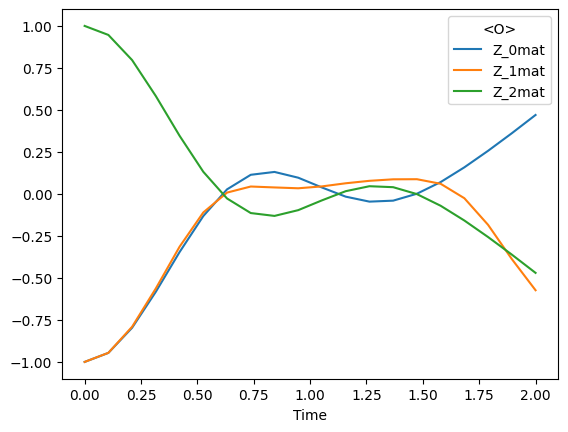

In [9]:
trotter_evolution_df.plot()

## Circuit Implementation

- We can implement first order trotterisation using the `TrotterPauliExpBox` class and its `power()` method

$$ e^{-i H t} = (e^{-i a_1  P_1 t / n} e^{-i  a_2 P_2 t / n} \cdots )^n$$

- The circuits can be seen below:

In [10]:
from qtnmtts.circuits.trotter import TrotterPauliExpBox
from pytket.circuit.display import render_circuit_jupyter
time_slice = end_time / n_time_steps
trotter_circ = TrotterPauliExpBox(op, n_state_qubits, time_slice).power(2).get_circuit()
render_circuit_jupyter(trotter_circ)

- This can be appended to the initial state circuit using the `RegisterCircuit.add_registerbox()` and the `QRegMap`

In [11]:
from qtnmtts.circuits.core import QRegMap

def time_evo_circ(power:int)-> RegisterCircuit:
    trotter_box = TrotterPauliExpBox(op, n_state_qubits, time_slice)
    qregmap = QRegMap(trotter_circ.q_registers, initial_circ.q_registers)
    if power == 0:
        return initial_circ.copy()
    else:
        return initial_circ.copy().add_registerbox(trotter_box.power(power), qregmap)



- The trotter circuits only have a single register called `state_qreg`

In [12]:
trotter_box = TrotterPauliExpBox(op, n_state_qubits, time_slice)
trotter_box.qreg.state

QubitRegister("q", 3)

- Here we calculate the expectation value of the Hamiltonian using the the statevector method `qtnmtts.measurement.statevector.operator_expectation_statevector()`. However we could also use the `qtnmtts.measurement.shots.operator_expectation` if we wanted to use shots or real hardware.

In [13]:
from qtnmtts.measurement.statevector import operator_expectation_statevector
from pytket.extensions.qulacs import QulacsBackend

backend = QulacsBackend()
def measure_circ(trotter_evolution_circ:RegisterCircuit) -> list[float]:
    return [operator_expectation_statevector(trotter_evolution_circ, operator, backend) for operator in measurements]

In [14]:
trotter_evolution = {time: measure_circ(time_evo_circ(power)) for power, time in enumerate(time_space)}

In [15]:
trotter_evo_circ_df = pd.DataFrame.from_dict(trotter_evolution, orient='index',columns=[f'Z_{i}circ' for i in range(len(measurements_mat))]).rename_axis('Time').rename_axis('<O>', axis='columns')

<Axes: xlabel='Time'>

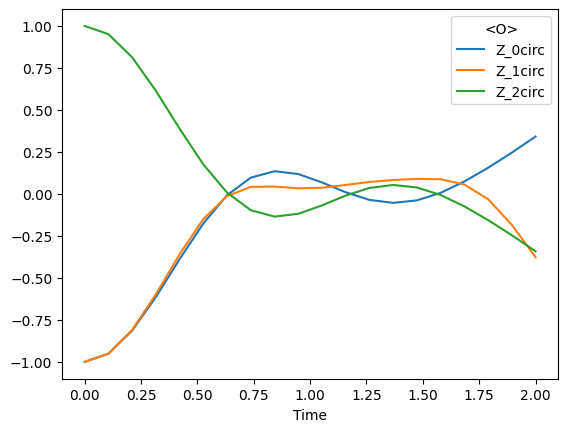

In [16]:
trotter_evo_circ_df.plot()

- Comparing the two methods we can see that the circuit implementation is not as accurate as the exact scipy implementation due to the trotter error.

/Users/nathanfitzpatric/Github/qtnm-tts/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nathanfitzpatric/Github/qtnm-tts/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: xlabel='Time'>

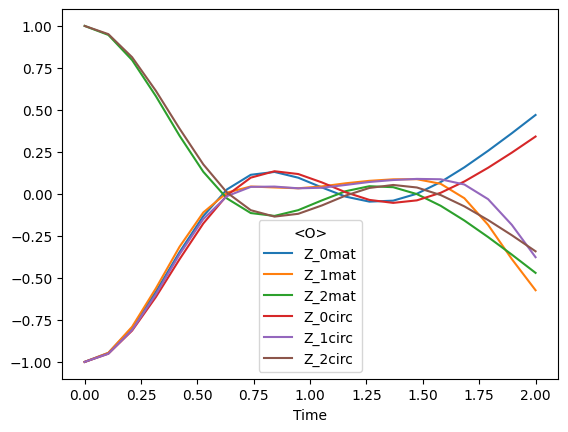

In [17]:
concat_df = pd.concat([trotter_evolution_df, trotter_evo_circ_df], axis=1)
concat_df.plot()

## Controlled Trotterisation

- Controlled Trotterisation is very useful for NISQ phase estimation methods
- It can be implemented using the `TrotterPauliExpBox` class and its `qcontrol()` method

In [18]:
from qtnmtts.circuits.core import RegisterCircuit

qc_trotter = trotter_box.qcontrol(1)

render_circuit_jupyter(qc_trotter.get_circuit())

In [19]:
qc_trotter_power = trotter_box.qcontrol(1).power(4)

render_circuit_jupyter(qc_trotter_power.get_circuit())